In [1]:
import torch
import gpytorch
import random
from gpytorch.likelihoods import GaussianLikelihood, DirichletClassificationLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_model
from gpytorch.constraints import Interval
import matplotlib.pyplot as plt
import numpy as np


import matplotlib.pyplot as plt
from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.acquisition.objective import IdentityMCObjective
from botorch.fit import fit_gpytorch_model
from botorch.models import ModelListGP, SingleTaskGP
from botorch.models.transforms.outcome import Standardize
from botorch.optim import optimize_acqf
from botorch.utils.sampling import sample_hypersphere
from botorch.utils.transforms import t_batch_mode_transform
from gpytorch.constraints import Interval
from gpytorch.likelihoods import GaussianLikelihood
from torch.quasirandom import SobolEngine
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
from alse.eci import ExpectedCoverageImprovement

In [2]:
tkwargs = {
    "device": torch.device("cpu"),
    "dtype": torch.float,
}

In [3]:
import pandas
real_data = pandas.read_excel('data1.xlsx')

power = torch.tensor(real_data.loc[:,"P (W)"])
velocity = torch.tensor(real_data.loc[:,"V (mm/min)"])
width = torch.tensor(real_data.loc[:,"widths avg (mm)"]).unsqueeze(-1)
pow_cap = torch.tensor(real_data.loc[:,"powder capt %"]/100).unsqueeze(-1)

X = torch.stack((power, velocity), -1)

In [4]:
X=(X-200)/2800

In [5]:
def get_and_fit_gp(X, Y):
    assert Y.ndim == 2 and Y.shape[-1] == 1
    likelihood = GaussianLikelihood(noise_constraint=Interval(1e-9, 1e-6))  # Noise-free
    gp = SingleTaskGP(X, Y, likelihood=likelihood)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_model(mll)
    return gp

In [6]:
gp_model_width = get_and_fit_gp(X, width)
gp_model_pow_cap = get_and_fit_gp(X, pow_cap)


In [7]:
N1, N2 = 100, 100
Xplt, Yplt = torch.meshgrid(
    torch.linspace(200, 3000, N1, **tkwargs), torch.linspace(200, 3000, N2, **tkwargs),
    indexing='xy',
)
xplt = torch.stack(
    (
        torch.reshape(Xplt, (Xplt.shape[0] * Xplt.shape[1],)),
        torch.reshape(Yplt, (Yplt.shape[0] * Yplt.shape[1],)),
    ),
    dim=1,
)

In [8]:
predicted_width = gp_model_width(xplt/3000).loc.detach().reshape(N1,N2)
predicted_pow_cap = gp_model_pow_cap(xplt/3000).loc.detach().reshape(N1,N2)

In [9]:
test_point = torch.tensor([[1500,  2600]])
gp_model_width(test_point.float()).loc.detach()

tensor([2.1562])

In [10]:
gp_model_width.covar_module.base_kernel.lengthscale

tensor([[0.3578, 0.2805]], grad_fn=<SoftplusBackward0>)

In [11]:
X=X*2800+200

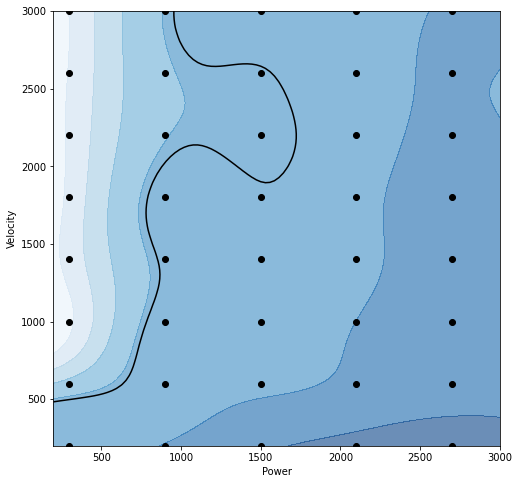

In [12]:
plt.subplots(figsize=(8, 8))
plt.contourf(Xplt, Yplt, predicted_width, cmap="Blues", alpha=0.6)
plt.contour(Xplt, Yplt, predicted_width, [2.5], colors="k")
plt.xlabel("Power")
plt.ylabel("Velocity")
plt.plot(X[:,0], X[:,1], "ko")


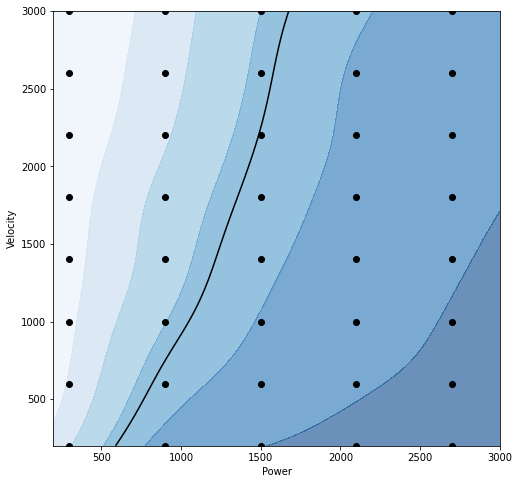

In [13]:
plt.subplots(figsize=(8, 8))
plt.contourf(Xplt, Yplt, predicted_pow_cap, cmap="Blues", alpha=0.6)
plt.contour(Xplt, Yplt, predicted_pow_cap, [0.5], colors="k")
plt.xlabel("Power")
plt.ylabel("Velocity")
plt.plot(X[:,0], X[:,1], "ko")

In [14]:
            #   width > 2.5  powder capture > 50%
constraints = [("gt", 2.5), ("gt", 0.5)]
punchout_radius = 0.001
bounds = torch.tensor([[200, 200], [3000, 3000]], **tkwargs)
lb, ub = bounds


In [15]:

# We don't have to normalize X since the domain is [0, 1]^2. Make sure to
# appropriately adjust the punchout radius if the domain is normalized.

model_list_gp = ModelListGP(gp_model_width, gp_model_pow_cap)

eci = ExpectedCoverageImprovement(
    model=model_list_gp,
    constraints=constraints,
    punchout_radius=punchout_radius,
    bounds=bounds,
    num_samples=512
)

x_next, _ = optimize_acqf(
    acq_function=eci,
    bounds=bounds,
    q=1,
    num_restarts=10,
    raw_samples=512
)

print(f"New X {x_next}")

New X tensor([[ 714.5535, 2984.3408]])
